In [137]:
import numpy as np
from numba import njit
from scipy.ndimage import laplace
from tqdm import tqdm
import matplotlib.pyplot as plt

BASESHIFT = np.array([-1, 0, 1])

In [138]:
class State:
    def __init__(self, L, N, q):
        self.L = L # lattice size
        self.N = N # number of anyons
        self.q = q # anyons
        self.Φ = np.zeros((L, L), dtype = np.float32) # field
    def draw(self):
        plt.imshow(self.q)
        plt.colorbar()
        plt.show()

In [139]:
def init_state(L, p_anyon):
    vert_anyons = (np.random.rand(L, L) < p_anyon).astype(int)
    vert_anyons += np.roll(vert_anyons, 1, axis=0)

    horiz_anyons = (np.random.rand(L, L) < p_anyon).astype(int)
    horiz_anyons += np.roll(horiz_anyons, 1, axis=1)
    
    q = (vert_anyons + horiz_anyons) % 2
    N = np.sum(q)
    return State(L, N, q)

In [140]:
def update_field(state, η):
    state.Φ += η / 4 * laplace(state.Φ, mode = 'wrap')
    state.Φ += state.q

In [141]:
def update_anyon(state):
    for x, y in np.transpose(np.nonzero(state.q)):
        idx = x * state.L + y
        shifts = np.add.outer(BASESHIFT * state.L, BASESHIFT).flatten()
        neighborhood = state.Φ.take(shifts + idx, mode = 'wrap')
        neighborhood = neighborhood[1::2]
        direction = neighborhood.argmax()
        if np.random.rand() < 0.5:
            state.q[x, y] -= 1
            state.q[x, y] %= 2
            if direction == 0:
                state.q[(x - 1) % state.L, y] += 1
                state.q[(x - 1) % state.L, y] %= 2
            elif direction == 1:
                state.q[x, (y - 1) % state.L] += 1
                state.q[x, (y - 1) % state.L] %= 2
            elif direction == 2:
                state.q[x, (y + 1) % state.L] += 1
                state.q[x, (y + 1) % state.L] %= 2
            elif direction == 3:
                state.q[(x + 1) % state.L, y] += 1
                state.q[(x + 1) % state.L, y] %= 2
            else:
                raise ValueError("Invalid direction")

  0%|          | 0/10 [00:00<?, ?it/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


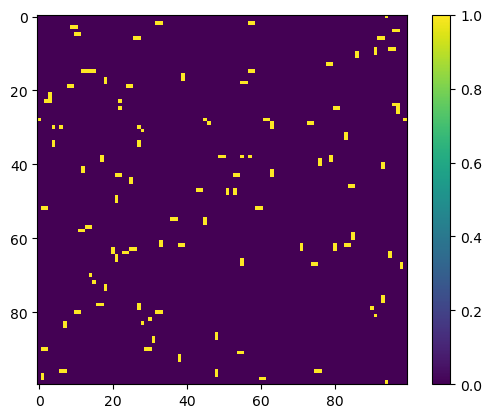

 10%|█         | 1/10 [00:01<00:10,  1.19s/it]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


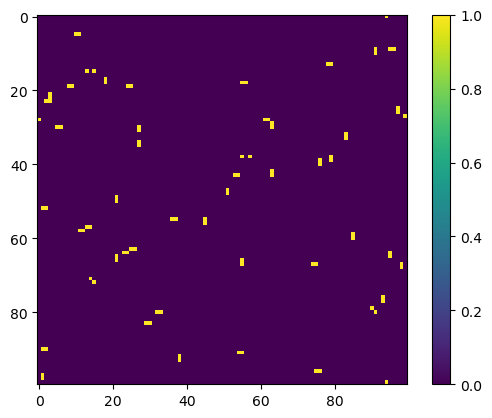

 20%|██        | 2/10 [00:02<00:09,  1.14s/it]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


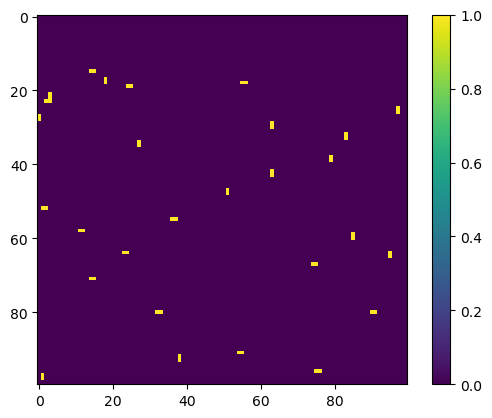

 30%|███       | 3/10 [00:03<00:06,  1.01it/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


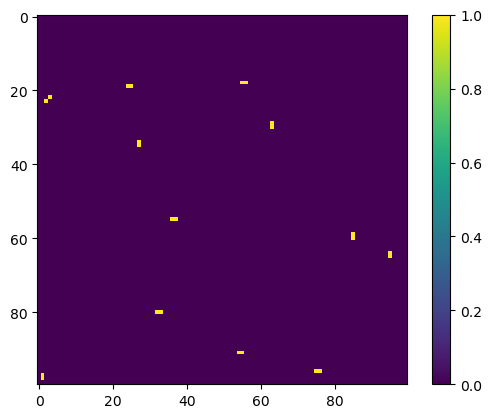

 40%|████      | 4/10 [00:03<00:04,  1.23it/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


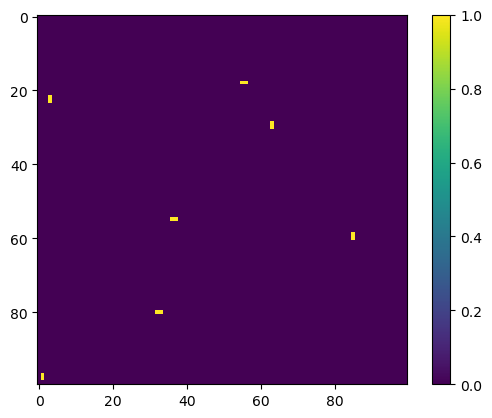

 50%|█████     | 5/10 [00:04<00:03,  1.40it/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


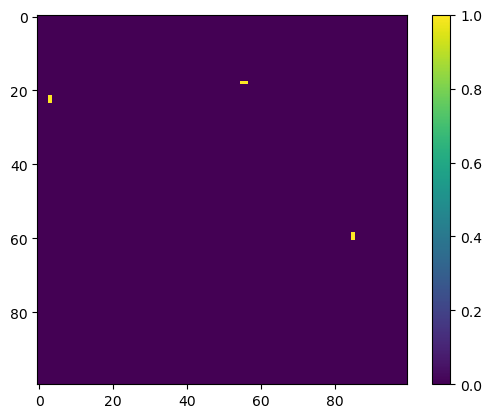

 60%|██████    | 6/10 [00:04<00:02,  1.57it/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


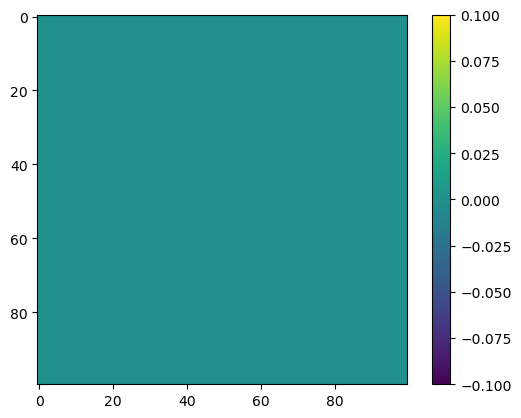

 70%|███████   | 7/10 [00:05<00:01,  1.59it/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


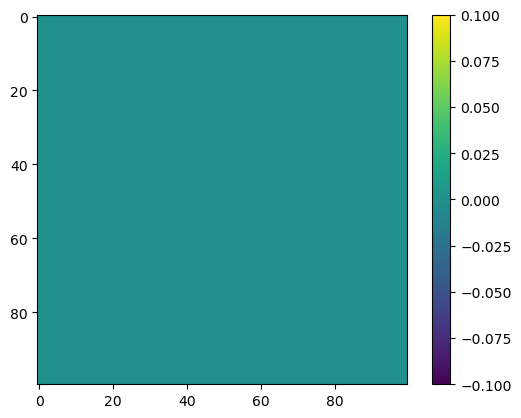

 80%|████████  | 8/10 [00:05<00:01,  1.64it/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


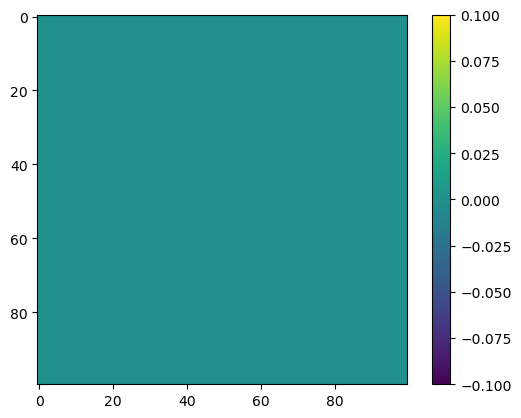

 90%|█████████ | 9/10 [00:07<00:00,  1.23it/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


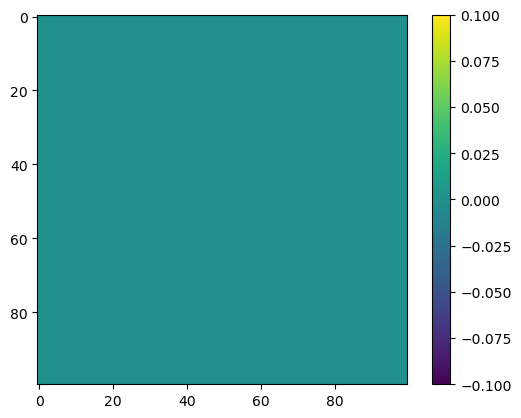

100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


In [142]:
mystate = init_state(100, 0.01)
c = 2
η = 0.5
T = 10

for i in tqdm(range(T)):
    for j in range(c):
        update_field(mystate, 1)
    update_anyon(mystate)
    mystate.draw()